# Import

In [1]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

import os
import warnings
#filter warnings
warnings.filterwarnings('ignore')

# Data Preparation

In [2]:
DATA_DIR = '/kaggle/input/cats-breed-dataset/cat_v1'

**Let's Understand the Data Distribution**

In [3]:
def count_images_in_subfolders(folder_path):
    class_counts = {}
    
    for subdir in os.listdir(folder_path):
        subdir_path = os.path.join(folder_path, subdir)
        file_count = len(os.listdir(subdir_path))
        class_counts[subdir] = file_count
    
    return class_counts

In [4]:
class_counts = count_images_in_subfolders(DATA_DIR)

#Extract data
classes = list(class_counts.keys())
counts = list(class_counts.values())


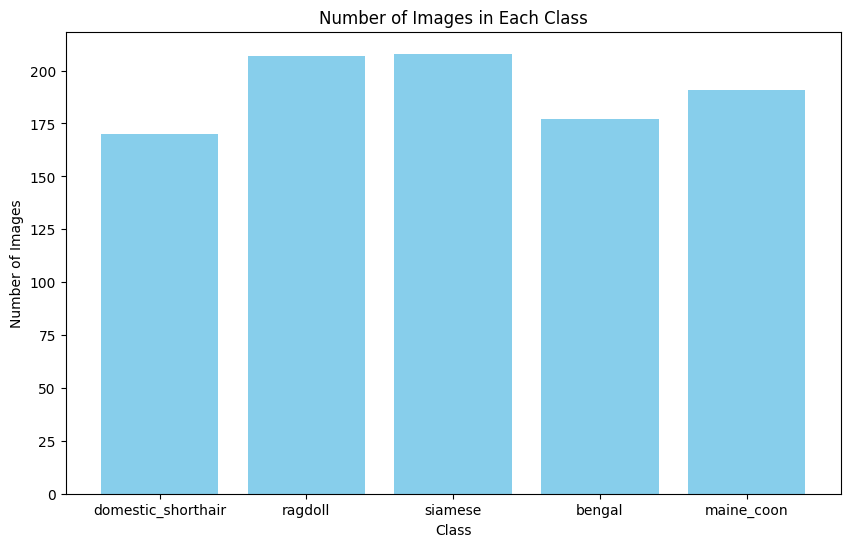

In [5]:
# Bar Plot
plt.figure(figsize = (10,6))
plt.bar(classes, counts, color = 'skyblue')
plt.xlabel("Class")
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Class')
plt.show()

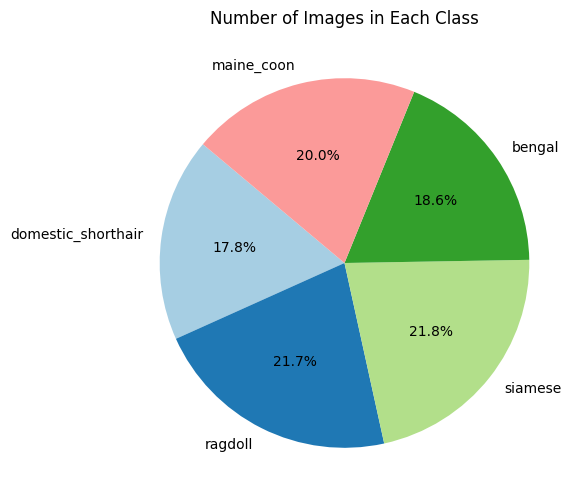

In [6]:
# Pie Plot
plt.figure(figsize = (10,6))
plt.pie(counts, labels = classes,autopct = '%1.1f%%',startangle = 140, colors = plt.cm.Paired.colors)
plt.title('Number of Images in Each Class')
plt.show()

**Let's Look at a sample**

Image shape (1104, 1120, 3)


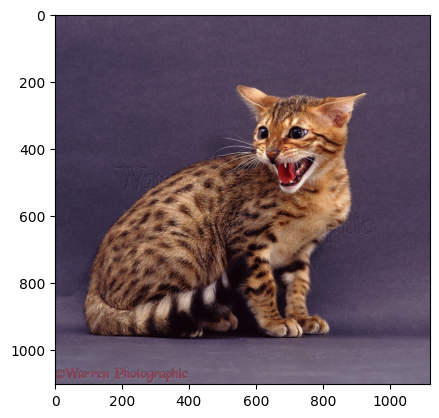

In [7]:
sample_img = cv2.imread('/kaggle/input/cats-breed-dataset/cat_v1/bengal/00438-Bengal-cat-snarling.jpg')
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
print('Image shape', sample_img.shape)

In [8]:
!pip install split_folders
import splitfolders

!mkdir './data-split'

splitfolders.ratio(DATA_DIR, output='./data-split', seed=1337, ratio=(.8, .1, .1), group_prefix=None)

Copying files: 953 files [00:11, 80.87 files/s] 


**Configuration**

In [9]:
TRAIN_DIR = '/kaggle/working/data-split/train'
TEST_DIR = '/kaggle/working/data-split/test'
VAL_DIR = '/kaggle/working/data-split/val'

In [10]:
BATCH_SIZE = 24
IMG_DIM = 224
NUM_CLASSES = len(os.listdir(DATA_DIR))

# Data Loaders

**Train Data w/Augmentations**

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen=ImageDataGenerator(
    rotation_range=20,      
    horizontal_flip=True,   
    vertical_flip=True,
    brightness_range=[0.8, 1.2],  
)

train_generator=train_datagen.flow_from_directory(
                                                 directory = TRAIN_DIR, 
                                                 target_size=(IMG_DIM, IMG_DIM),
                                                 color_mode='rgb',
                                                 batch_size=BATCH_SIZE,
                                                 class_mode='categorical',
)


2024-05-29 18:38:05.808735: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-29 18:38:05.808880: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-29 18:38:05.935262: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 758 images belonging to 5 classes.


**Let's Look at the Augmentations**

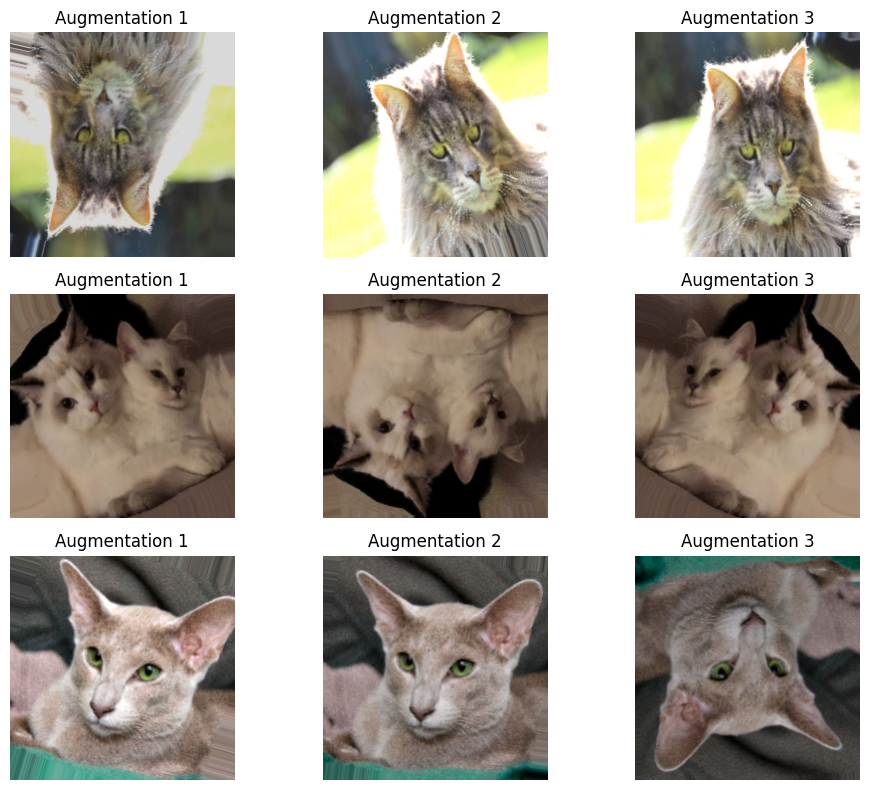

In [12]:
def plot_augmentations(generator):
    x_batch, y_batch = next(generator)
    fig, axes = plt.subplots(3, 3, figsize=(10, 8))

    for i in range(3):
        for j in range(3):
            aug_image = train_datagen.random_transform(x_batch[i])
            axes[i, j].imshow(aug_image.astype(np.uint8))
            axes[i, j].set_title('Augmentation {}'.format(j + 1))
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

# Plot the augmentations
plot_augmentations(train_generator)

 **Validation and Test**

In [13]:
val_datagen = ImageDataGenerator() 

val_generator = val_datagen.flow_from_directory(
    directory=VAL_DIR, 
    target_size=(IMG_DIM, IMG_DIM),
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)
test_datagen=ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(IMG_DIM, IMG_DIM),
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode=None,
    shuffle=False
)

Found 93 images belonging to 5 classes.
Found 100 images belonging to 5 classes.


## CNN Model

# Transfer Learning - Using a Pretrained Model

You can also look at building basic CNN models in earlier versions of this notebook.


**Create the Model**

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, Rescaling
from tensorflow.keras.applications import EfficientNetB4

md = EfficientNetB4(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_DIM, IMG_DIM, 3),
    pooling='max'
)

model = Sequential([
    # preprocessing layer is included as part of EfficientNetB4, read relevant documentation when using other models
    md,
    Dense(128, activation="relu"),
    Dropout(0.25),
    Dense(NUM_CLASSES, activation="softmax")
])

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


# Compile the Model

In [15]:
from keras.optimizers import Adam
optimizer = Adam()

model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics=['accuracy'])

# Train the Model - Fine Tuning

In [16]:
epochs = 16
# Fit the model
history = model.fit(train_generator, epochs = epochs, validation_data = val_generator)

Epoch 1/16


I0000 00:00:1717008232.521283     146 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32/32 ━━━━━━━━━━━━━━━━━━━━ 486s 7s/step - accuracy: 0.4102 - loss: 3.2189 - val_accuracy: 0.7957 - val_loss: 0.9949
Epoch 2/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.7430 - loss: 0.7856 - val_accuracy: 0.7419 - val_loss: 0.9099
Epoch 3/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.8281 - loss: 0.5683 - val_accuracy: 0.7742 - val_loss: 0.8956
Epoch 4/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.8261 - loss: 0.4726 - val_accuracy: 0.7204 - val_loss: 0.8424
Epoch 5/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.8934 - loss: 0.3288 - val_accuracy: 0.8172 - val_loss: 0.5266
Epoch 6/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.9246 - loss: 0.2971 - val_accuracy: 0.7419 - val_loss: 0.8175
Epoch 7/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.8814 - loss: 0.3854 - val_accuracy: 0.7527 - val_loss: 1.5785
Epoch 8/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.9131 - loss: 0.2762 - val_accuracy: 0.7957 - val_loss: 0.5944
Ep

# Plot Traing Results

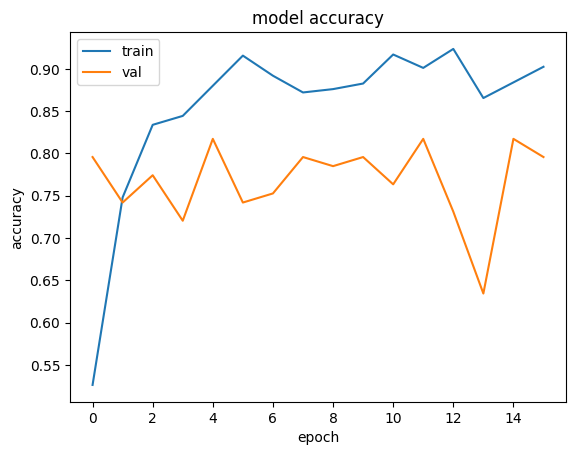

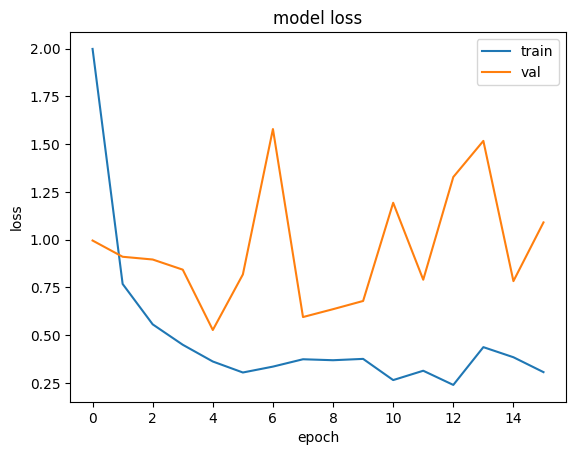

In [17]:
plt.figure(1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'val'], loc ='upper left')

plt.figure(2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

# Evaluate on Test Set

In [18]:
# Make predictions
test_generator.reset()
test_preds = model.predict(test_generator, verbose=1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step 


## Results


Test Data Classification Report
                    precision    recall  f1-score   support

            bengal       0.94      0.79      0.86        19
domestic_shorthair       0.58      0.82      0.68        17
        maine_coon       0.88      0.75      0.81        20
           ragdoll       0.76      0.59      0.67        22
           siamese       0.58      0.68      0.62        22

          accuracy                           0.72       100
         macro avg       0.75      0.73      0.73       100
      weighted avg       0.75      0.72      0.73       100



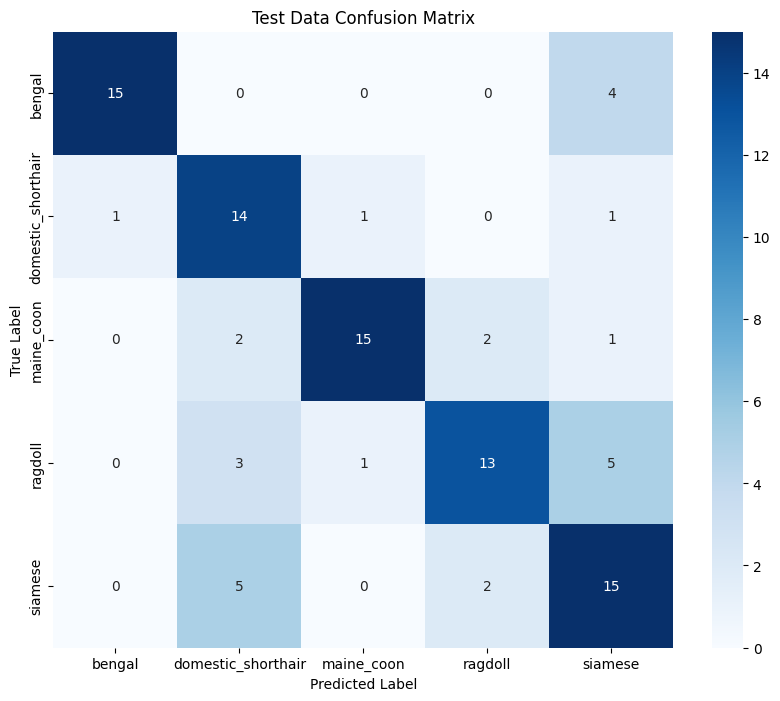

In [19]:
# Convert to class labels
test_pred_classes = np.argmax(test_preds, axis =1)

# Get true labels
test_true_classes = test_generator.classes

# Classification report
test_class_report = classification_report(test_true_classes,test_pred_classes, target_names = test_generator.class_indices.keys())

print('\nTest Data Classification Report')
print(test_class_report)

# Confusion matrix
test_cm = confusion_matrix(test_true_classes, test_pred_classes)

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
# Plot test confusion matrix
plot_confusion_matrix(test_cm, classes =test_generator.class_indices.keys(), title ='Test Data Confusion Matrix')

In [20]:
# remove redundant data
!rm -rf ./data-split